# Installing the required dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

Added six different libraries
- Tensorflow
- Tensoflow-gpu
- openCV (Computer Vision library)
- mediapipe (allows to get keypoints from your face and head)
- sklearn
- matplotlib

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Implement the keypoints and mediapipe holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing the utilities

In [8]:
# Defining the function to detect our image based on the model
def mediapipe_detection(image, model):
    # This line helps in the color conversion from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # This makes the image no longer writable.
    image.flags.writeable = False
    
    # helps make the prediction
    results = model.process(image)
    
    # Makes the image writable.
    image.flags.writeable = True
    
    # This converts the color again from RGB to BGR.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Returns our image and results back to our loop.
    return image, results

In [9]:
# this function grabs the results and maps landmarks to the image.
def draw_landmarks(image,results):
    # Draws the points on the face
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    # Draws the points on the pose
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    # Draws the points on the Right Hand
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    # Draws the points on the left Hand
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [10]:
# Run this new function for improved data points on the live stream

def draw_styled_landmarks(image,results):
    # Draws the points on the face
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
    # Draws the points on the pose
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    # Draws the points on the Right Hand
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    # Draws the points on the left Hand
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1))

In [12]:
# writing a loop to do a video capture

cap = cv2.VideoCapture(0)

# Setting the mediapipe model while capturing image.
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened(): #opens the webcam

        #Reads the feed from the webcam
        ret, frame = cap.read()

        # Inserting the detection code below.
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw the landmarks to our live feed
        #draw_landmarks(image, results)
        draw_styled_landmarks(image, results)
        
        #shows the feed to the screen, pass the frame or image from webcam.
        cv2.imshow('OpenCV Feed', image)

        # Stops the video once we escape from the loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # After the break it will let go of our webcam.
    cap.release()
    # Deletes or closes the window.
    cv2.destroyAllWindows()

In [13]:
len(results.pose_world_landmarks.landmark)

33

In [14]:
draw_styled_landmarks(frame, results)

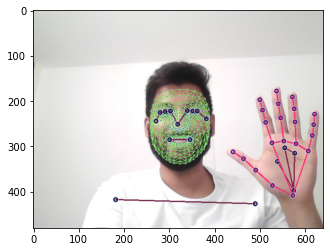

In [15]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract the keypoint values from the output

In [16]:
# Concatenate results values into a numpy array
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()if results.right_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()if results.right_hand_landmarks else np.zeros(1404)
    return np.concatenate([pose,face,lh,rh])

In [17]:
extract_keypoints(results).shape

(1662,)

In [18]:
result_test = extract_keypoints(results)

In [19]:
result_test

array([ 0.49950686,  0.5242393 , -1.52327859, ...,  0.        ,
        0.        ,  0.        ])

In [ ]:
np.save('0', result_test)

In [ ]:
np.load('0.npy')

# Setting up the folder for creating the collection

In [20]:
# Creating the path to export the data of numpy array
DATA_PATH = os.path.join('MP_data')

# Specify the actions that need to be detected.
actions = np.array(['hello', 'thanks','Iloveyou'])

# Specify the number of videos of data to select.
no_sequences = 30

# Video are be 30 frames in length
sequence_length = 30

In [ ]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Collecting keypoint values for training and testing our data.

In [ ]:
# writing a loop to take a snapshot in each point of time.

cap = cv2.VideoCapture(0)

# Setting the mediapipe model while capturing image.
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through each action
    for action in actions:
        # Loops through the sequences in videos
        for sequence in range(no_sequences):
            #Loop through video length aka sequence length
            for frame_num in range(sequence_length):
        

                #Reads the feed from the webcam
                ret, frame = cap.read()

                # Inserting the detection code below.
                image, results = mediapipe_detection(frame, holistic)
                #print(results)


                # Draw the landmarks to our live feed
                #draw_landmarks(image, results)
                draw_styled_landmarks(image, results)

                # Apply the logic for collecting 

                # If frame is 0 then excute the following
                if frame_num == 0:

                    #The following code outputs text in our screen
                    cv2.putText(image, 'STARTING COLLECTION',(120,200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)

                    cv2.putText(image, 'Collecting frame for {} Video Number {}'.format(action,sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting frame for {} Video Number {}'.format(action, sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)


                # This code collects the keypoints and saves it in the root folder.
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)


                #shows the feed to the screen, pass the frame or image from webcam.
                cv2.imshow('OpenCV Feed', image)

                # Stops the video once we escape from the loop
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    # After the break it will let go of our webcam.
    cap.release()
    # Deletes or closes the window.
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# Preprocess our data and create the labels and features from the recorded material

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [22]:
label_map = {label:num for num, label in enumerate(actions)}

In [23]:
label_map

{'hello': 0, 'thanks': 1, 'Iloveyou': 2}

In [24]:

# Creating two new blank array, sequences is representing our X data and labels will be the Y data.
sequences, labels = [], []

# Created a loop through each of our actions.
for action in actions:
    # Loop through each of the thirty videos
    for sequence in range(no_sequences):
        # For each loop we will create a blank window array, reps all the frames for a sequence
        window = []
        # Loop for each frame
        for frame_num in range(sequence_length):
            # Loads the file and the appends to the window.
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
            # Grabbing the video and appending to the window.
        sequences.append(window)
        labels.append(label_map[action])

In [25]:
X = np.array(sequences)

In [26]:
X.shape

(90, 30, 1662)

In [27]:
y = to_categorical(labels).astype(int)

In [28]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# Build and train our LSTM neural network!

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [35]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [52]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation = 'relu', input_shape = (30,1662)))
model.add(LSTM(128, return_sequences=True, activation = 'relu'))
model.add(LSTM(64, return_sequences=False, activation = 'relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [53]:
# Compile our model. Using the categorical crossentropy as we have a multi-class classificational model.
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [40]:
# Fitting our model.
model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 3s 429ms/step - loss: 1.4330 - categorical_accuracy: 0.3072
Epoch 2/2000
3/3 [==============================] - 0s 44ms/step - loss: 8.4743 - categorical_accuracy: 0.3190
Epoch 3/2000
3/3 [==============================] - 0s 43ms/step - loss: 2.9885 - categorical_accuracy: 0.4110
Epoch 4/2000
3/3 [==============================] - 0s 40ms/step - loss: 6.2730 - categorical_accuracy: 0.4794
Epoch 5/2000
3/3 [==============================] - 0s 41ms/step - loss: 3.7251 - categorical_accuracy: 0.4324
Epoch 6/2000
3/3 [==============================] - 0s 42ms/step - loss: 5.7228 - categorical_accuracy: 0.4266
Epoch 7/2000
3/3 [==============================] - 0s 43ms/step - loss: 6.3153 - categorical_accuracy: 0.4168
Epoch 8/2000
3/3 [==============================] - 0s 41ms/step - loss: 12.9938 - categorical_accuracy: 0.3190
Epoch 9/2000
3/3 [==============================] - 0s 38ms/step - loss: 9.2143 - categorical_accuracy: 0.2466

3/3 [==============================] - 0s 40ms/step - loss: 34.3426 - categorical_accuracy: 0.2761
Epoch 74/2000
3/3 [==============================] - 0s 40ms/step - loss: 50.5981 - categorical_accuracy: 0.2329
Epoch 75/2000
3/3 [==============================] - 0s 38ms/step - loss: 43.2495 - categorical_accuracy: 0.3659
Epoch 76/2000
3/3 [==============================] - 0s 41ms/step - loss: 92.9803 - categorical_accuracy: 0.3600
Epoch 77/2000
3/3 [==============================] - 0s 41ms/step - loss: 42.5771 - categorical_accuracy: 0.4051
Epoch 78/2000
3/3 [==============================] - 0s 40ms/step - loss: 121.6691 - categorical_accuracy: 0.4208
Epoch 79/2000
3/3 [==============================] - 0s 39ms/step - loss: 45.3444 - categorical_accuracy: 0.2485
Epoch 80/2000
3/3 [==============================] - 0s 40ms/step - loss: 111.6536 - categorical_accuracy: 0.3034
Epoch 81/2000
3/3 [==============================] - 0s 40ms/step - loss: 63.5796 - categorical_accuracy: 0.

3/3 [==============================] - 0s 52ms/step - loss: 7.6559 - categorical_accuracy: 0.4481
Epoch 146/2000
3/3 [==============================] - 0s 41ms/step - loss: 8.0778 - categorical_accuracy: 0.4246
Epoch 147/2000
3/3 [==============================] - 0s 43ms/step - loss: 17.4151 - categorical_accuracy: 0.3659
Epoch 148/2000
3/3 [==============================] - 0s 45ms/step - loss: 14.0428 - categorical_accuracy: 0.2897
Epoch 149/2000
3/3 [==============================] - 0s 41ms/step - loss: 12.9354 - categorical_accuracy: 0.3698
Epoch 150/2000
3/3 [==============================] - 0s 44ms/step - loss: 6.9481 - categorical_accuracy: 0.3875
Epoch 151/2000
3/3 [==============================] - 0s 46ms/step - loss: 27.5831 - categorical_accuracy: 0.2936
Epoch 152/2000
3/3 [==============================] - 0s 43ms/step - loss: 21.7288 - categorical_accuracy: 0.3640
Epoch 153/2000
3/3 [==============================] - 0s 41ms/step - loss: 8.0252 - categorical_accuracy: 

3/3 [==============================] - 0s 44ms/step - loss: 20.6093 - categorical_accuracy: 0.3620
Epoch 218/2000
3/3 [==============================] - 0s 41ms/step - loss: 18.0590 - categorical_accuracy: 0.2720
Epoch 219/2000
3/3 [==============================] - 0s 41ms/step - loss: 5.3196 - categorical_accuracy: 0.4089
Epoch 220/2000
3/3 [==============================] - 0s 47ms/step - loss: 15.8503 - categorical_accuracy: 0.3034
Epoch 221/2000
3/3 [==============================] - 0s 40ms/step - loss: 9.5393 - categorical_accuracy: 0.3679
Epoch 222/2000
3/3 [==============================] - 0s 40ms/step - loss: 6.6143 - categorical_accuracy: 0.2232
Epoch 223/2000
3/3 [==============================] - 0s 42ms/step - loss: 13.6858 - categorical_accuracy: 0.3307
Epoch 224/2000
3/3 [==============================] - 0s 45ms/step - loss: 7.8866 - categorical_accuracy: 0.3660
Epoch 225/2000
3/3 [==============================] - 0s 42ms/step - loss: 5.7237 - categorical_accuracy: 0

3/3 [==============================] - 0s 39ms/step - loss: 2.5185 - categorical_accuracy: 0.3719
Epoch 290/2000
3/3 [==============================] - 0s 42ms/step - loss: 2.5170 - categorical_accuracy: 0.3855
Epoch 291/2000
3/3 [==============================] - 0s 39ms/step - loss: 2.6589 - categorical_accuracy: 0.4149
Epoch 292/2000
3/3 [==============================] - 0s 43ms/step - loss: 3.1748 - categorical_accuracy: 0.3444
Epoch 293/2000
3/3 [==============================] - 0s 41ms/step - loss: 2.1872 - categorical_accuracy: 0.3777
Epoch 294/2000
3/3 [==============================] - 0s 41ms/step - loss: 2.0592 - categorical_accuracy: 0.4716
Epoch 295/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.9400 - categorical_accuracy: 0.3894
Epoch 296/2000
3/3 [==============================] - 0s 48ms/step - loss: 1.3438 - categorical_accuracy: 0.3620
Epoch 297/2000
3/3 [==============================] - 0s 42ms/step - loss: 2.5753 - categorical_accuracy: 0.432

3/3 [==============================] - 0s 41ms/step - loss: 3.0664 - categorical_accuracy: 0.4716
Epoch 362/2000
3/3 [==============================] - 0s 42ms/step - loss: 2.4509 - categorical_accuracy: 0.3718
Epoch 363/2000
3/3 [==============================] - 0s 41ms/step - loss: 3.0481 - categorical_accuracy: 0.4306
Epoch 364/2000
3/3 [==============================] - 0s 38ms/step - loss: 1.6577 - categorical_accuracy: 0.4422
Epoch 365/2000
3/3 [==============================] - 0s 41ms/step - loss: 2.9017 - categorical_accuracy: 0.3894
Epoch 366/2000
3/3 [==============================] - 0s 48ms/step - loss: 5.0969 - categorical_accuracy: 0.3464
Epoch 367/2000
3/3 [==============================] - 0s 50ms/step - loss: 7.5729 - categorical_accuracy: 0.3816
Epoch 368/2000
3/3 [==============================] - 0s 50ms/step - loss: 5.0167 - categorical_accuracy: 0.3464
Epoch 369/2000
3/3 [==============================] - 0s 40ms/step - loss: 4.5255 - categorical_accuracy: 0.367

3/3 [==============================] - 0s 40ms/step - loss: 0.9450 - categorical_accuracy: 0.4677
Epoch 434/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.0441 - categorical_accuracy: 0.4247
Epoch 435/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.2601 - categorical_accuracy: 0.4267
Epoch 436/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.4969 - categorical_accuracy: 0.4756
Epoch 437/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.1560 - categorical_accuracy: 0.3483
Epoch 438/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.1329 - categorical_accuracy: 0.4872
Epoch 439/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.0753 - categorical_accuracy: 0.5792
Epoch 440/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.1099 - categorical_accuracy: 0.5244
Epoch 441/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.2027 - categorical_accuracy: 0.573

3/3 [==============================] - 0s 41ms/step - loss: 0.8974 - categorical_accuracy: 0.6145
Epoch 506/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.8992 - categorical_accuracy: 0.5636
Epoch 507/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.9595 - categorical_accuracy: 0.5167
Epoch 508/2000
3/3 [==============================] - 0s 42ms/step - loss: 0.8232 - categorical_accuracy: 0.6261
Epoch 509/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.0165 - categorical_accuracy: 0.5578
Epoch 510/2000
3/3 [==============================] - 0s 42ms/step - loss: 0.8477 - categorical_accuracy: 0.6047
Epoch 511/2000
3/3 [==============================] - 0s 42ms/step - loss: 0.9730 - categorical_accuracy: 0.4775
Epoch 512/2000
3/3 [==============================] - 0s 44ms/step - loss: 0.8574 - categorical_accuracy: 0.5538
Epoch 513/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.8682 - categorical_accuracy: 0.645

3/3 [==============================] - 0s 37ms/step - loss: 1.0609 - categorical_accuracy: 0.5421
Epoch 578/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.1870 - categorical_accuracy: 0.5500
Epoch 579/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.9834 - categorical_accuracy: 0.5656
Epoch 580/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.0031 - categorical_accuracy: 0.5989
Epoch 581/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.8681 - categorical_accuracy: 0.6380
Epoch 582/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.0842 - categorical_accuracy: 0.5832
Epoch 583/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.9729 - categorical_accuracy: 0.5186
Epoch 584/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.9594 - categorical_accuracy: 0.7006
Epoch 585/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.8724 - categorical_accuracy: 0.602

3/3 [==============================] - 0s 41ms/step - loss: 0.8180 - categorical_accuracy: 0.7123
Epoch 650/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.7508 - categorical_accuracy: 0.6908
Epoch 651/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.8260 - categorical_accuracy: 0.6419
Epoch 652/2000
3/3 [==============================] - 0s 43ms/step - loss: 0.9107 - categorical_accuracy: 0.7299
Epoch 653/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.0543 - categorical_accuracy: 0.6262
Epoch 654/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.0826 - categorical_accuracy: 0.7104
Epoch 655/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.0246 - categorical_accuracy: 0.6281
Epoch 656/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.9673 - categorical_accuracy: 0.6066
Epoch 657/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.8293 - categorical_accuracy: 0.665

3/3 [==============================] - 0s 40ms/step - loss: 0.9785 - categorical_accuracy: 0.6145
Epoch 722/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.9641 - categorical_accuracy: 0.6399
Epoch 723/2000
3/3 [==============================] - 0s 42ms/step - loss: 0.8735 - categorical_accuracy: 0.7358
Epoch 724/2000
3/3 [==============================] - 0s 54ms/step - loss: 1.1730 - categorical_accuracy: 0.6399
Epoch 725/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.8925 - categorical_accuracy: 0.6927
Epoch 726/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.2941 - categorical_accuracy: 0.5206
Epoch 727/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.2014 - categorical_accuracy: 0.6223
Epoch 728/2000
3/3 [==============================] - 0s 43ms/step - loss: 1.0861 - categorical_accuracy: 0.7534
Epoch 729/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.9498 - categorical_accuracy: 0.618

3/3 [==============================] - 0s 49ms/step - loss: 0.6827 - categorical_accuracy: 0.6653
Epoch 794/2000
3/3 [==============================] - 0s 43ms/step - loss: 0.6686 - categorical_accuracy: 0.6341
Epoch 795/2000
3/3 [==============================] - 0s 42ms/step - loss: 0.6726 - categorical_accuracy: 0.6282
Epoch 796/2000
3/3 [==============================] - 0s 43ms/step - loss: 0.7148 - categorical_accuracy: 0.6321
Epoch 797/2000
3/3 [==============================] - 0s 37ms/step - loss: 0.6956 - categorical_accuracy: 0.6771
Epoch 798/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.6692 - categorical_accuracy: 0.7103
Epoch 799/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.6937 - categorical_accuracy: 0.6536
Epoch 800/2000
3/3 [==============================] - 0s 43ms/step - loss: 0.7003 - categorical_accuracy: 0.6517
Epoch 801/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.8131 - categorical_accuracy: 0.681

3/3 [==============================] - 0s 41ms/step - loss: 0.7483 - categorical_accuracy: 0.7338
Epoch 866/2000
3/3 [==============================] - 0s 43ms/step - loss: 0.7427 - categorical_accuracy: 0.7279
Epoch 867/2000
3/3 [==============================] - 0s 47ms/step - loss: 0.8018 - categorical_accuracy: 0.7358
Epoch 868/2000
3/3 [==============================] - 0s 44ms/step - loss: 1.0915 - categorical_accuracy: 0.6516
Epoch 869/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.7273 - categorical_accuracy: 0.6986
Epoch 870/2000
3/3 [==============================] - 0s 44ms/step - loss: 0.7708 - categorical_accuracy: 0.6263
Epoch 871/2000
3/3 [==============================] - 0s 42ms/step - loss: 0.6982 - categorical_accuracy: 0.7240
Epoch 872/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.7244 - categorical_accuracy: 0.7318
Epoch 873/2000
3/3 [==============================] - 0s 44ms/step - loss: 0.7961 - categorical_accuracy: 0.675

3/3 [==============================] - 0s 41ms/step - loss: 0.6595 - categorical_accuracy: 0.6849
Epoch 938/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.6051 - categorical_accuracy: 0.6947
Epoch 939/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.6997 - categorical_accuracy: 0.6497
Epoch 940/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.7643 - categorical_accuracy: 0.6966
Epoch 941/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.8216 - categorical_accuracy: 0.6047
Epoch 942/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.6987 - categorical_accuracy: 0.6262
Epoch 943/2000
3/3 [==============================] - 0s 38ms/step - loss: 0.6720 - categorical_accuracy: 0.6712
Epoch 944/2000
3/3 [==============================] - 0s 43ms/step - loss: 0.7168 - categorical_accuracy: 0.6262
Epoch 945/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.7757 - categorical_accuracy: 0.608

3/3 [==============================] - 0s 52ms/step - loss: 0.6627 - categorical_accuracy: 0.6869
Epoch 1010/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.6951 - categorical_accuracy: 0.6067
Epoch 1011/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.6125 - categorical_accuracy: 0.6478
Epoch 1012/2000
3/3 [==============================] - 0s 47ms/step - loss: 0.6073 - categorical_accuracy: 0.6653
Epoch 1013/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.7081 - categorical_accuracy: 0.5949
Epoch 1014/2000
3/3 [==============================] - 0s 51ms/step - loss: 0.6141 - categorical_accuracy: 0.6790
Epoch 1015/2000
3/3 [==============================] - 0s 42ms/step - loss: 0.5657 - categorical_accuracy: 0.6966
Epoch 1016/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.5815 - categorical_accuracy: 0.6830
Epoch 1017/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.5565 - categorical_accurac

3/3 [==============================] - 0s 41ms/step - loss: 4.3487 - categorical_accuracy: 0.3836
Epoch 1081/2000
3/3 [==============================] - 0s 40ms/step - loss: 3.5808 - categorical_accuracy: 0.5086
Epoch 1082/2000
3/3 [==============================] - 0s 40ms/step - loss: 4.2164 - categorical_accuracy: 0.2427
Epoch 1083/2000
3/3 [==============================] - 0s 42ms/step - loss: 3.3230 - categorical_accuracy: 0.3797
Epoch 1084/2000
3/3 [==============================] - 0s 43ms/step - loss: 6.8988 - categorical_accuracy: 0.4814
Epoch 1085/2000
3/3 [==============================] - 0s 41ms/step - loss: 2.2301 - categorical_accuracy: 0.3582
Epoch 1086/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.5477 - categorical_accuracy: 0.4795
Epoch 1087/2000
3/3 [==============================] - 0s 44ms/step - loss: 1.7420 - categorical_accuracy: 0.4580
Epoch 1088/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.7923 - categorical_accurac

3/3 [==============================] - 0s 44ms/step - loss: 0.9997 - categorical_accuracy: 0.4461
Epoch 1153/2000
3/3 [==============================] - 0s 43ms/step - loss: 1.0500 - categorical_accuracy: 0.5088
Epoch 1154/2000
3/3 [==============================] - 0s 42ms/step - loss: 0.9770 - categorical_accuracy: 0.4345
Epoch 1155/2000
3/3 [==============================] - 0s 43ms/step - loss: 1.3250 - categorical_accuracy: 0.5558
Epoch 1156/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.0141 - categorical_accuracy: 0.6047
Epoch 1157/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.2450 - categorical_accuracy: 0.4365
Epoch 1158/2000
3/3 [==============================] - 0s 46ms/step - loss: 1.0893 - categorical_accuracy: 0.5284
Epoch 1159/2000
3/3 [==============================] - 0s 45ms/step - loss: 1.4388 - categorical_accuracy: 0.5381
Epoch 1160/2000
3/3 [==============================] - 0s 43ms/step - loss: 1.4057 - categorical_accurac

3/3 [==============================] - 0s 42ms/step - loss: 1.2592 - categorical_accuracy: 0.5167
Epoch 1225/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.9460 - categorical_accuracy: 0.5909
Epoch 1226/2000
3/3 [==============================] - 0s 60ms/step - loss: 1.2405 - categorical_accuracy: 0.6223
Epoch 1227/2000
3/3 [==============================] - 0s 48ms/step - loss: 0.9639 - categorical_accuracy: 0.5675
Epoch 1228/2000
3/3 [==============================] - 0s 43ms/step - loss: 1.2693 - categorical_accuracy: 0.6145
Epoch 1229/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.3981 - categorical_accuracy: 0.4579
Epoch 1230/2000
3/3 [==============================] - 0s 45ms/step - loss: 1.4514 - categorical_accuracy: 0.6282
Epoch 1231/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.2883 - categorical_accuracy: 0.5284
Epoch 1232/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.4425 - categorical_accurac

3/3 [==============================] - 0s 42ms/step - loss: 0.8189 - categorical_accuracy: 0.5813
Epoch 1297/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.7671 - categorical_accuracy: 0.6321
Epoch 1298/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.7600 - categorical_accuracy: 0.6673
Epoch 1299/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.9440 - categorical_accuracy: 0.6086
Epoch 1300/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.9554 - categorical_accuracy: 0.5050
Epoch 1301/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.7688 - categorical_accuracy: 0.6653
Epoch 1302/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.7997 - categorical_accuracy: 0.6381
Epoch 1303/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.0155 - categorical_accuracy: 0.6399
Epoch 1304/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.9873 - categorical_accurac

3/3 [==============================] - 0s 39ms/step - loss: 0.8141 - categorical_accuracy: 0.5890
Epoch 1369/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.8420 - categorical_accuracy: 0.6144
Epoch 1370/2000
3/3 [==============================] - 0s 38ms/step - loss: 0.8637 - categorical_accuracy: 0.6145
Epoch 1371/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.8547 - categorical_accuracy: 0.5480
Epoch 1372/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.8981 - categorical_accuracy: 0.6086
Epoch 1373/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.8327 - categorical_accuracy: 0.5049
Epoch 1374/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.8181 - categorical_accuracy: 0.6477
Epoch 1375/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.8193 - categorical_accuracy: 0.6086
Epoch 1376/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.9187 - categorical_accurac

3/3 [==============================] - 0s 41ms/step - loss: 6.3457 - categorical_accuracy: 0.6771
Epoch 1441/2000
3/3 [==============================] - 0s 39ms/step - loss: 1149.0678 - categorical_accuracy: 0.2876
Epoch 1442/2000
3/3 [==============================] - 0s 39ms/step - loss: 910.2818 - categorical_accuracy: 0.3776
Epoch 1443/2000
3/3 [==============================] - 0s 40ms/step - loss: 246.9277 - categorical_accuracy: 0.3796
Epoch 1444/2000
3/3 [==============================] - 0s 41ms/step - loss: 184.3349 - categorical_accuracy: 0.3365
Epoch 1445/2000
3/3 [==============================] - 0s 40ms/step - loss: 158.6528 - categorical_accuracy: 0.3347
Epoch 1446/2000
3/3 [==============================] - 0s 40ms/step - loss: 130.1769 - categorical_accuracy: 0.3601
Epoch 1447/2000
3/3 [==============================] - 0s 40ms/step - loss: 119.1032 - categorical_accuracy: 0.2780
Epoch 1448/2000
3/3 [==============================] - 0s 41ms/step - loss: 1294.5411 - c

3/3 [==============================] - 0s 46ms/step - loss: 1.2234 - categorical_accuracy: 0.3229
Epoch 1512/2000
3/3 [==============================] - 0s 52ms/step - loss: 1.2091 - categorical_accuracy: 0.3386
Epoch 1513/2000
3/3 [==============================] - 0s 46ms/step - loss: 1.1971 - categorical_accuracy: 0.3151
Epoch 1514/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.1426 - categorical_accuracy: 0.3854
Epoch 1515/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.1591 - categorical_accuracy: 0.3815
Epoch 1516/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.1580 - categorical_accuracy: 0.3620
Epoch 1517/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.1954 - categorical_accuracy: 0.3307
Epoch 1518/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.1544 - categorical_accuracy: 0.3815
Epoch 1519/2000
3/3 [==============================] - 0s 43ms/step - loss: 1.1670 - categorical_accurac

3/3 [==============================] - 0s 39ms/step - loss: 1.1447 - categorical_accuracy: 0.3386
Epoch 1584/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.1289 - categorical_accuracy: 0.3268
Epoch 1585/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.1306 - categorical_accuracy: 0.3268
Epoch 1586/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.1280 - categorical_accuracy: 0.3698
Epoch 1587/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.1605 - categorical_accuracy: 0.2995
Epoch 1588/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.1605 - categorical_accuracy: 0.3190
Epoch 1589/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.1422 - categorical_accuracy: 0.3307
Epoch 1590/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.1332 - categorical_accuracy: 0.3464
Epoch 1591/2000
3/3 [==============================] - 0s 38ms/step - loss: 1.1401 - categorical_accurac

3/3 [==============================] - 0s 39ms/step - loss: 1.1359 - categorical_accuracy: 0.3073
Epoch 1656/2000
3/3 [==============================] - 0s 37ms/step - loss: 1.1118 - categorical_accuracy: 0.3503
Epoch 1657/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.1340 - categorical_accuracy: 0.3151
Epoch 1658/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.0975 - categorical_accuracy: 0.3347
Epoch 1659/2000
3/3 [==============================] - 0s 38ms/step - loss: 1.1197 - categorical_accuracy: 0.3386
Epoch 1660/2000
3/3 [==============================] - 0s 38ms/step - loss: 1.1202 - categorical_accuracy: 0.3347
Epoch 1661/2000
3/3 [==============================] - 0s 38ms/step - loss: 1.1144 - categorical_accuracy: 0.3386
Epoch 1662/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.1177 - categorical_accuracy: 0.3581
Epoch 1663/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.1253 - categorical_accurac

3/3 [==============================] - 0s 42ms/step - loss: 1.0946 - categorical_accuracy: 0.3659
Epoch 1728/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.1046 - categorical_accuracy: 0.3268
Epoch 1729/2000
3/3 [==============================] - 0s 43ms/step - loss: 1.0962 - categorical_accuracy: 0.3776
Epoch 1730/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.1077 - categorical_accuracy: 0.3503
Epoch 1731/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.1129 - categorical_accuracy: 0.3347
Epoch 1732/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.1203 - categorical_accuracy: 0.3386
Epoch 1733/2000
3/3 [==============================] - 0s 44ms/step - loss: 1.1073 - categorical_accuracy: 0.3190
Epoch 1734/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.0933 - categorical_accuracy: 0.3620
Epoch 1735/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.1041 - categorical_accurac

3/3 [==============================] - 0s 41ms/step - loss: 1.1013 - categorical_accuracy: 0.3581
Epoch 1800/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.0971 - categorical_accuracy: 0.3581
Epoch 1801/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.0970 - categorical_accuracy: 0.3307
Epoch 1802/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.0995 - categorical_accuracy: 0.3190
Epoch 1803/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.1077 - categorical_accuracy: 0.3229
Epoch 1804/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.0989 - categorical_accuracy: 0.3347
Epoch 1805/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.1068 - categorical_accuracy: 0.3425
Epoch 1806/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.1040 - categorical_accuracy: 0.3347
Epoch 1807/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.0996 - categorical_accurac

3/3 [==============================] - 0s 42ms/step - loss: 1.0906 - categorical_accuracy: 0.3737
Epoch 1872/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.1040 - categorical_accuracy: 0.3268
Epoch 1873/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.1017 - categorical_accuracy: 0.3034
Epoch 1874/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.0930 - categorical_accuracy: 0.3112
Epoch 1875/2000
3/3 [==============================] - 0s 46ms/step - loss: 1.0963 - categorical_accuracy: 0.3151
Epoch 1876/2000
3/3 [==============================] - 0s 54ms/step - loss: 1.0899 - categorical_accuracy: 0.3659
Epoch 1877/2000
3/3 [==============================] - 0s 49ms/step - loss: 1.0996 - categorical_accuracy: 0.3307
Epoch 1878/2000
3/3 [==============================] - 0s 53ms/step - loss: 1.1018 - categorical_accuracy: 0.2722
Epoch 1879/2000
3/3 [==============================] - 0s 55ms/step - loss: 1.1020 - categorical_accurac

3/3 [==============================] - 0s 39ms/step - loss: 1.0914 - categorical_accuracy: 0.3679
Epoch 1944/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.0963 - categorical_accuracy: 0.3679
Epoch 1945/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.0957 - categorical_accuracy: 0.3444
Epoch 1946/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.1022 - categorical_accuracy: 0.3288
Epoch 1947/2000
3/3 [==============================] - 0s 50ms/step - loss: 1.1010 - categorical_accuracy: 0.3835
Epoch 1948/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.0915 - categorical_accuracy: 0.3601
Epoch 1949/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.0976 - categorical_accuracy: 0.3679
Epoch 1950/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.0919 - categorical_accuracy: 0.3913
Epoch 1951/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.0951 - categorical_accurac

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 64)            442112    
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
________________________________________________

# Make the prediction

In [42]:
res = model.predict(X_test)

In [43]:
actions[np.argmax(res[0])]

'Iloveyou'

# Save the weights

In [49]:
model.save('action.h5')

In [50]:
del model

In [54]:
model.load_weights('action.h5')

# Evaluate our model using a confusion matrix and accuracy

In [56]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [57]:
yhat = model.predict(X_test)

In [58]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [59]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4., 0.],
        [1., 0.]],

       [[1., 0.],
        [4., 0.]],

       [[0., 5.],
        [0., 0.]]])

In [60]:
accuracy_score(ytrue, yhat) # LMAOOOO its 0 :')

0.0